In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [19]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/SamSung.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [34]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [35]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=18372.971, Time=2.64 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18366.192, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=18369.533, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=18369.570, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=18365.152, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=18367.593, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=18367.631, Time=0.18 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=18368.330, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=18368.114, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=18368.112, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=18367.208, Time=0.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 5.473 seconds


In [36]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([72000.        , 72076.99827024, 71769.00518929, 71615.00864882,
       71384.01383811, 71230.01729764, 71461.01210834, 72000.        ,
       72230.99481071, 72307.99308095, 72384.99135118, 72923.97924284,
       72384.99135118, 72769.98270236, 73077.97578331, 72846.9809726 ,
       72153.99654047, 71384.01383811, 70614.03113574, 71461.01210834,
       71846.00345953, 72307.99308095, 72923.97924284, 73000.97751307,
       73000.97751307, 72461.98962142, 71461.01210834, 70614.03113574,
       70999.02248693, 70691.02940598, 70768.02767622, 71615.00864882,
       72153.99654047, 71076.02075716, 71230.01729764, 71076.02075716,
       70460.03459527, 69613.05362267, 69690.05189291, 69613.05362267,
       69998.04497385, 69151.06400125, 69382.05881196, 68689.07437983,
       68073.08821794, 67842.09340723, 67765.095137  , 68073.08821794,
       68535.07783936, 68073.08821794, 69305.06054172, 68304.08302865,
       67996.0899477 , 68150.08648818, 68535.07783936, 68150.08648818,
      

In [37]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([72000.        , 72076.99827024, 71769.00518929, 71615.00864882,
       71384.01383811, 71230.01729764, 71461.01210834, 72000.        ,
       72230.99481071, 72307.99308095, 72384.99135118, 72923.97924284,
       72384.99135118, 72769.98270236, 73077.97578331, 72846.9809726 ,
       72153.99654047, 71384.01383811, 70614.03113574, 71461.01210834,
       71846.00345953, 72307.99308095, 72923.97924284, 73000.97751307,
       73000.97751307, 72461.98962142, 71461.01210834, 70614.03113574,
       70999.02248693, 70691.02940598, 70768.02767622, 71615.00864882,
       72153.99654047, 71076.02075716, 71230.01729764, 71076.02075716,
       70460.03459527, 69613.05362267, 69690.05189291, 69613.05362267,
       69998.04497385, 69151.06400125, 69382.05881196, 68689.07437983,
       68073.08821794, 67842.09340723, 67765.095137  , 68073.08821794,
       68535.07783936, 68073.08821794, 69305.06054172, 68304.08302865,
       67996.0899477 , 68150.08648818, 68535.07783936, 68150.08648818,
      

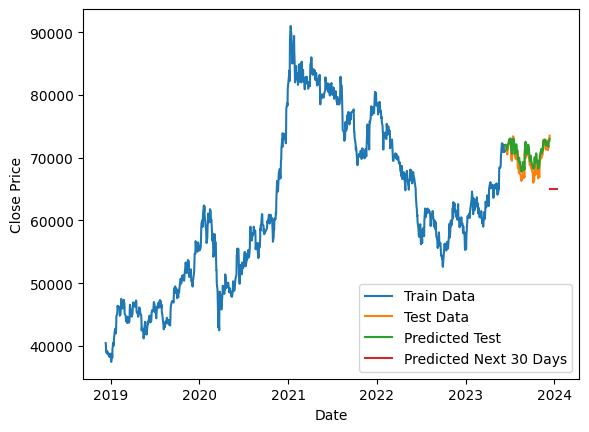

In [38]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [39]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 785.521
Testing RMSE: 972.168
Testing MAPE: 1.141


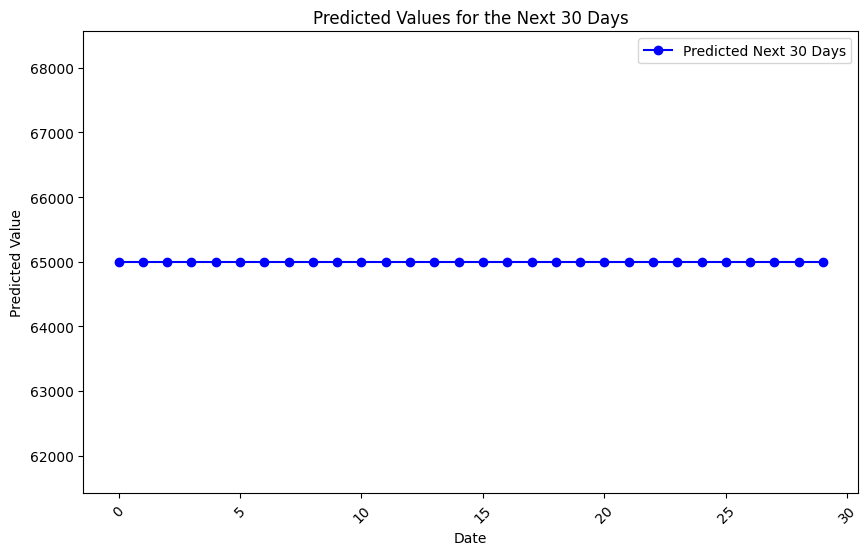

In [40]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


